In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, mean_squared_error, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier as SKVotingClassifier
from sklearn.cross_validation import StratifiedKFold, KFold
from collections import Counter
import pprint
import time
import sys
import pickle
import math

%matplotlib inline

In [2]:
def intersection(s1, s2):
    s = set(s2)
    return filter(lambda x: x in s, s1)

In [3]:
def gini(y):
    hist = Counter(y)
    return 1. - np.sum(np.array(hist.values()) / float(len(y)))**2

def mse(y):
    return np.var(y) * len(y)

class Node:
    def __init__(self, depth, max_depth, impurity, min_samples_split, is_leaf=False):
        self.is_leaf = is_leaf
        self.depth = depth
        self.max_depth = max_depth
        self.impurity = impurity
        self.min_samples_split = min_samples_split
        
    def stopping_criteria(self, X, y):
        if X.shape[0] <= self.min_samples_split:
            return True
        
        if self.max_depth is not None and self.depth >= self.max_depth:
            return True
                
        if self.impurity == 'gini':        
            return np.unique(y).shape[0] == 1
        
    def get_answer(self, y):
        if self.impurity == 'gini':
            return Counter(y).most_common()[0][0]
        else:                
            return np.mean(y)
    
    def get_impurity_change(self, y, y_left, y_right):
        if self.impurity == 'gini':
            return gini(y) - gini(y_left) * len(y_left) / len(y) - gini(y_right) * len(y_right) / len(y)
        else:
            return mse(y) - mse(y_left) * len(y_left) / len(y) - mse(y_right) * len(y_right) / len(y)
        
    def get_predicate(self, X, y, table, indices):
        m = X.shape[1]
        
        best_feature = None
        best_threshold = None
        best_impurity = None
        best_index = None
    
        for feature in np.arange(m):
            if self.impurity == 'gini':
                hist_left = Counter([])
                hist_right = Counter(y[indices])
                            
                square_sum_left, square_sum_right = 0, np.sum(np.array(hist_right.values())**2)
            else:
                sum_left, sum_right = 0, np.sum(y[indices])                
            
            table_feature = intersection(table[feature], indices)
            
            n = len(table_feature)
            
            for ind, k in enumerate(table_feature[:-1]):

                if self.impurity == 'gini':
                    square_sum_left += 2 * hist_left[y[k]] + 1
                    square_sum_right -= 2 * hist_right[y[k]] - 1

                    hist_left[y[k]] += 1
                    hist_right[y[k]] -= 1

                    new_impurity = -float(square_sum_left) / (ind+1) - float(square_sum_right) / (n-ind-1)
                else:
                    sum_left += y[k]
                    sum_right -= y[k]
                    
                    new_impurity = -sum_left**2 / float(ind+1) - sum_right**2 / float(n-ind-1)

                if X[table_feature[ind+1], feature] > X[k, feature]:
                    
                    if best_feature is None or new_impurity < best_impurity:
                        threshold = (X[k, feature] + X[table_feature[ind+1], feature]) / 2.

                        best_feature = feature
                        best_threshold = threshold
                        best_impurity = new_impurity
                        best_index = ind+1                        
                
        if best_feature is not None:
            table_feature = intersection(table[best_feature], indices)

            best_left  = table_feature[:best_index]
            best_right = table_feature[best_index:]
                        
            self.var_importance = len(indices) * self.get_impurity_change(y[indices], y[best_left], y[best_right]) / X.shape[0]
        else:
            best_left  = None
            best_right = None        
                
        return best_feature, best_threshold, best_left, best_right
        
    def fit(self, X, y, table, indices):
        
        if self.stopping_criteria(X[indices], y[indices]):
            self.is_leaf = True
            self.answer = self.get_answer(y[indices])
            return
        
        #t = time.time()
        self.feature, self.threshold, left, right = self.get_predicate(X, y, table, indices)
        #print "Split: ", time.time() - t

        if self.feature is None:
            self.is_leaf = True
            self.answer = self.get_answer(y[indices])            
            return

        self.left = Node(self.depth + 1, max_depth=self.max_depth, impurity=self.impurity, min_samples_split=self.min_samples_split)
        self.left.fit(X, y, table, left)

        self.right = Node(self.depth + 1, max_depth=self.max_depth, impurity=self.impurity, min_samples_split=self.min_samples_split)
        self.right.fit(X, y, table, right)
    
    def predict(self, X):
        if self.is_leaf:
            return self.answer
        else:
            if X[self.feature] <= self.threshold:
                return self.left.predict(X)
            else:
                return self.right.predict(X)
            
    def get_feature_scores(self):
        if self.is_leaf:
            return Counter([])
        
        left_scores = self.left.get_feature_scores()
        right_scores = self.right.get_feature_scores()
        
        scores = left_scores + right_scores
        scores[self.feature] += self.var_importance
        
        return scores
        
class CART:
    def __init__(self, impurity='gini', max_depth=None, min_samples_split=2):
        if impurity not in ['gini', 'mse']:
            raise ValueError("Only gini and mse criteria are supported")
        self.impurity = impurity
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, y):
        
        table = X.argsort(axis=0).T
        indices = np.arange(X.shape[0])
        
        self.root = Node(0, max_depth=self.max_depth, impurity=self.impurity, min_samples_split=self.min_samples_split)
        self.root.fit(X, y, table, indices)
        return self
        
    def predict(self, X):
        answer = []
        for x in X:
            answer.append(self.root.predict(x))
        return np.array(answer)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_feature_scores(self):
        return self.root.get_feature_scores()        

In [4]:
def shuffle(df, train_percent=0.8):
    X = np.copy(df.values)
    np.random.shuffle(X)
    
    X, y = X[:, :-1], X[:, -1]
    
    train_size = int(X.shape[0] * train_percent)
    
    X_train, y_train = X[:train_size, :], y[:train_size]
    X_test, y_test = X[train_size:, :], y[train_size:]
    
    return X_train, y_train, X_test, y_test

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [6]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, poi=1.0, pof=1.0, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.poi = poi
        self.pof = pof
        
        self.min_samples_split = min_samples_split
            
    def fit(self, X, y):
        
        print "Fitting random forest with {} estimators".format(self.n_estimators)
        
        self.estimators = []
        self.estimators_features = []
        
        self.oob_score = []
           
        #np.random.seed(1543*1543)
        np.random.seed(1)
    
        i = 0
        for _ in xrange(self.n_estimators):
            
            i += 1
            print "Fitting estimator number {}".format(i)
            
            n, m = X.shape
            items    = np.sort(np.random.choice(n, n * self.poi))
            features = np.sort(np.random.choice(m, m * self.pof, replace=False))
            
            mask = np.ones((X.shape[0],), dtype=bool)
            mask[items] = 0
            
            #estimator = CART(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            estimator = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            #estimator = DecisionTreeClassifier()
            estimator.fit(X[:, features][items, :], y[items])
            
            self.estimators.append(estimator)
            self.estimators_features.append(features)
                        
            self.oob_score.append(estimator.score(X[:, features][mask, :], y[mask]))
        #print "OOB score: {}".format(np.mean(self.oob_score))        
    
    def predict(self, X):
        answer = 0
        
        prob = [Counter([])] * X.shape[0]
        
        for e, f, s in zip(self.estimators, self.estimators_features, self.oob_score):
            p = e.predict(X[:, f])
            answer += p

            for i, a in enumerate(p):
                prob[i][a] += 1
                
        answer /= self.n_estimators
        answer = np.sign(answer)
                    
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)        
        return np.mean(pred == y)
    
    def get_feature_scores(self):
        feature_scores = Counter([])
        for e, ef in zip(self.estimators, self.estimators_features):
            scores = e.get_feature_scores()
            for f, s in scores.items():
                feature_scores[ef[f]] += s            
        return feature_scores

In [7]:
def binarize(y):
    return np.array([-1 if x < 0.0 else 1 for x in y])

In [8]:
class GradientBoosting:
    def __init__(self, n_estimators=10, max_depth=5, mu=0.1, min_samples_split=2, subsample=1.0, max_features=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.mu = mu
        self.min_samples_split = min_samples_split
        
        self.subsample = subsample
        self.max_features = max_features
        
    def loss(self, y_true, y_pred):
        return log_loss((y_true+1) / 2., (y_pred + 1) / 2.)
    
    def get_learning_rate(self, X, y, estimator):
        
        old = np.array(self.predict(X))
        new = np.array(estimator.predict(X))

        best_b = self.mu
        best_loss = float("+inf")
        
        b = 0.1
        while b <= 10.0:
            p = old + b * self.mu * new
            p = binarize(p)
            
            loss = self.loss(y, p)
            
            if loss <= best_loss:                
                best_b = b
                best_loss = loss
                
            b += 0.1
        
        b = 10.0
        while b <= 100.0:
            p = old + b * self.mu * new
            p = binarize(p)
            
            loss = self.loss(y, p)
            if loss <= best_loss:
                
                best_b = b
                best_loss = loss
                
            b += 1.0
        
        return self.mu * b    
    
    def fit(self, X, y):
        
        print "Fitting gradient boosting with {} estimators".format(self.n_estimators)
        
        self.estimators = []
        self.weigths = []
        
        n = X.shape[0]
        
        items = np.sort(np.random.choice(n, n * self.subsample))

        #estimator = CART(max_depth=1, impurity='mse')
        estimator = DecisionTreeRegressor(max_depth=1, min_samples_split=self.min_samples_split)
        estimator.fit(X[items], y[items])
        
        self.estimators.append(estimator)
        self.weigths.append(1.)
        
        old_loss = 0
        
        depth = self.max_depth        
        for i in xrange(self.n_estimators):
                    
            print "[Fitting estimator number {}]".format(i+1)
            
            h = self.predict(X)
            
            g = (y+1)/2. - sigmoid((h+1)/2.)
             
            loss = self.loss(y_true=y, y_pred=binarize(h))
            print "Score: ", np.mean(y == binarize(h))
            #loss = self.loss(y, h)        
            #print "Loss: {}\ndiff: {}".format(loss, loss - old_loss)                    
                        
            old_loss = loss
                    
            items = np.sort(np.random.choice(n, n * self.subsample, replace=False))
            #features = np.sort(np.random.choice(m, m * self.max_features, replace=False))
            
            #estimator = CART(max_depth=depth, impurity='mse', min_samples_split=self.min_samples_split)
            estimator = DecisionTreeRegressor(max_depth=depth, min_samples_split=self.min_samples_split)
            #estimator.fit(X, g)
                        
            #estimator.fit(X[:, features][items, :], y[items])
            estimator.fit(X[items], g[items])
            
            self.estimators.append(estimator)
            
            b = self.get_learning_rate(X, y, estimator)
            self.weigths.append(b)

    def predict(self, X):
        answer = 0
        for b, a in zip(self.weigths, self.estimators):
            answer += b * a.predict(X)
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(np.sign(pred) == y)
    
    def get_feature_scores(self):        
        feature_scores = Counter([])
        for w, e in zip(self.weigths, self.estimators):
            scores = e.get_feature_scores()
            for k in scores.keys():
                scores[k] *= w
            feature_scores += scores
        return feature_scores

In [27]:
class VotingClassifier:
    def __init__(self, estimators, weights=None, need_fit=False, lambd=1.0, max_iter=300):
        self.estimators = estimators
        self.weights = weights
        self.need_fit = need_fit
        self.was_fit = False
        self.lambd = lambd
        self.max_iter = max_iter
    
    def fit(self, X, y):
        if self.need_fit:
            for e in self.estimators:
                e.fit(X, y)
        
        if self.was_fit:
            self.weights = None
        
        if self.weights is not None:
            return
        
        self.weights = np.zeros((len(self.estimators),))
        
        predicts = np.concatenate(map(lambda e: [e.predict(X)], self.estimators)).T
                
        alpha = 0.0001
        
        eps = 0.001
        
        #print "Fitting voting classifier"        
        
        h = np.dot(predicts, self.weights)
        old_err = float('+inf')
        err = log_loss((y+1)/2, (binarize(h)+1)/2) + self.lambd * np.sum(self.weights**2)
        i = 0
        #while abs(err - old_err) > eps:
        while i < self.max_iter:
        
            #grad = np.dot(predicts.T, sigmoid(h) - y) / X.shape[0] + self.lambd * 2 * np.sum(self.weights) / X.shape[0]
            #grad = np.dot(predicts.T, sigmoid(h) - (y+1)/2.) / X.shape[0] + self.lambd * 2 * np.sum(self.weights) / X.shape[0]
            grad = np.dot(predicts.T, sigmoid(h) - (y+1)/2.) + self.lambd * 2 * np.sum(self.weights)
            self.weights -= alpha * grad
            
            if np.sum(grad**2 ) < eps:
                break
            
            h = np.dot(predicts, self.weights)
            old_err = err
            err = log_loss((y+1)/2, (binarize(h)+1)/2)
            
            print err
            i += 1
    
        self.was_fit = True
        
    def predict(self, X):
        answer = 0
        for weight, estimator in zip(self.weights, self.estimators):
            p = estimator.predict(X)            
            answer += weight * p
        answer = np.sign(answer / len(self.estimators))
        return answer
    
    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(pred == y)
    
    def get_feature_scores(self):
        feature_scores = Counter([])
        for w, e in zip(self.weights, self.estimators):
            scores = e.get_feature_scores()
            for k in scores.keys():
                scores[k] *= w
            feature_scores += scores
        return feature_scores

In [10]:
class iGBRT(GradientBoosting):
    def __init__(self, frst, n_estimators=10, max_depth=5, mu=0.1, min_samples_split=2, subsample=1.0, max_features=1.0):
        GradientBoosting.__init__(self, n_estimators, max_depth, mu, min_samples_split, subsample, max_features)        
        self.estimators = [frst]
        self.weigths = [1.]
        
    def fit(self, X, y):
        
        print "Fitting iGBRT with {} estimators".format(self.n_estimators)
                            
        n = X.shape[0]
        
        items = np.sort(np.random.choice(n, n * self.subsample))

        #estimator = CART(max_depth=1, impurity='mse')
        #estimator = DecisionTreeRegressor(max_depth=1, min_samples_split=self.min_samples_split)        
        self.estimators[0].fit(X[items], y[items])
        
        #self.estimators.append(estimator)
        #self.weigths.append(1.)
        
        old_loss = 0
        
        depth = self.max_depth        
        for i in xrange(self.n_estimators):
                    
            print "[Fitting estimator number {}]".format(i+1)
            
            h = self.predict(X)
            
            g = (y+1)/2. - sigmoid((h+1)/2.)
             
            loss = self.loss(y_true=y, y_pred=binarize(h))
            print "Score: ", np.mean(y == binarize(h))
            #loss = self.loss(y, h)        
            #print "Loss: {}\ndiff: {}".format(loss, loss - old_loss)                    
                        
            old_loss = loss
                    
            items = np.sort(np.random.choice(n, n * self.subsample, replace=False))
            #features = np.sort(np.random.choice(m, m * self.max_features, replace=False))
            
            #estimator = CART(max_depth=depth, impurity='mse', min_samples_split=self.min_samples_split)
            estimator = DecisionTreeRegressor(max_depth=depth, min_samples_split=self.min_samples_split)
            #estimator.fit(X, g)
                        
            #estimator.fit(X[:, features][items, :], y[items])
            estimator.fit(X[items], g[items])
            
            self.estimators.append(estimator)
            
            #b = self.get_learning_rate(X, y, estimator)
            b = self.mu
            self.weigths.append(b)


In [102]:
class BagBoo:
    def __init__(self, n_estimators, n_boost_estimators, subsample=0.7, max_depth=3):
        self.n_estimators = n_estimators
        self.subsample = subsample
        self.n_boost_estimators = n_boost_estimators
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.estimators = []
        
        for i in xrange(self.n_estimators):
            print "Fitting boosting number {}".format(i)
            estimator = GradientBoosting(n_estimators=self.n_boost_estimators, subsample=self.subsample, max_depth=self.max_depth, min_samples_split=5, mu=0.01)
            estimator.fit(X, y)
            self.estimators.append(estimator)
            
    def predict(self, X):
        answer = 0
        for e in self.estimators:
            answer += e.predict(X)
            
        return answer / self.n_estimators

In [157]:
from sklearn.cluster import KMeans

class ClusteringClassifier:
    def __init__(self, n_clusters, n_estimators):
        self.n_clusters = n_clusters
        self.n_estimators = n_estimators
        
    def fit(self, X, y):
        self.clust = KMeans(n_clusters=self.n_clusters)        
        clusters = self.clust.fit_predict(X)
        
        self.estimators = {}
        
        for c in np.unique(clusters):
            #estimator = RandomForest(n_estimators=self.n_estimators)
            estimator = GradientBoosting(n_estimators=self.n_estimators, min_samples_split=5, mu=0.01, max_depth=3, subsample=1.0)
            estimator.fit(X[clusters == c], y[clusters == c])
            self.estimators[c] = estimator
            
    def predict(self, X):
        clusters = self.clust.predict(X)
        
        answer = np.zeros(X.shape[0])
        
        for c in np.unique(clusters):
            answer[clusters == c] = np.sign(self.estimators[c].predict(X[clusters == c]))
            
        return answer

In [11]:
def CFS(X, y):    
    r = np.corrcoef(X, y.reshape(-1, 1), rowvar=0)
    ry = r[:, -1]
    r = r[:-1, :-1]
    
    best_all_score = None
    best_features = None
    all_features = []
    
    features = set([])
    
    ysum = 0.0
    pairsum = 0.0
    d = 0
    
    features_scores = Counter([])
    for i in xrange(X.shape[1]):
        best_score = None
        for f in xrange(X.shape[1]):
            if f not in features:
                score = (ysum + ry[f]) / math.sqrt(d + 1 + 2 * (pairsum + np.sum(r[f, list(features)])))
                if best_score is None or score > best_score:
                    best_score = score
                    best_feature = f
        
        d += 1
        pairsum += 2 * np.sum(r[best_feature, list(features)])
        ysum += ry[best_feature]
        
        features.add(best_feature)
        all_features.append((best_feature, best_score))
                    
        if best_all_score < best_score:
            best_all_score = best_score
            best_features = features
            
    return best_features, best_all_score, all_features

In [12]:
def J(X, y, feature_set, model):
    f1 = []
    for train_index, test_index in KFold(y.shape[0], n_folds=3, shuffle=True):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        model.fit(X_train, y_train)        
        p = model.predict(X_test)
        
        #f1.append(f1_score(np.array((y_test+1)/2, dtype=int), np.array((p+1)/2, dtype=int)))
        f1.append(precision_recall_fscore_support(np.array((y_test+1)/2, dtype=int), np.array((p+1)/2, dtype=int))[2].mean())
    return np.mean(f1)

def forward_selection(X, y, n, model):
    features = []
    scores = []
    
    best_features = None
    best_all_score = None
    
    current_features = set([])
    
    times = []
    
    for j in xrange(X.shape[1]):
        best_score = None
        best_feature = None
        
        t = time.time()
        
        for f in xrange(X.shape[1]): # Find best feature
            if f in current_features:
                continue

            #print "Trying feature number ", f
                
            current_set = current_features | set([f])
            score = J(X[:, list(current_set)], y, current_set, model)
            
            #print score, current_set
            
            if best_score is None or score > best_score:
                best_score = score
                best_feature = f
        
        features.append(best_feature)
        scores.append(best_score)
        
        print best_score
        
        current_features.add(best_feature) # Add new feature

#         if best_all_score is not None and best_score >= eta * best_all_score:
#             return best_features
        
        if best_all_score is None or best_all_score < best_score:
            best_all_score = best_score
            best_features = current_features
            best_j = j
            
        print "[Iteration number {}]".format(j)
        print "Best features so far: {}".format(best_features)
        print "Time elapsed on iteration: {}".format(time.time() - t)
        times.append(time.time() - t)
        sys.stdout.flush()
        
        #if j - best_j >= n:
            #return best_features
    
    return best_features, best_all_score, features, scores, times

In [ ]:
wrapper_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.03, max_depth=3)
wrapper_rf = RandomForestClassifier(n_estimators=50)

model = VotingClassifier([wrapper_gb, wrapper_rf], need_fit=True)

t = time.time()
wrapper_best_features, wrapper_best_score, wrapper_all_features, wrapper_all_scores, wrapper_times = forward_selection(spam_X_train, spam_y_train, 2, model)
print time.time() - t

In [ ]:
tosave = (wrapper_best_features, wrapper_best_score, wrapper_all_features, wrapper_all_scores)
wrapper_file = open('wrapper_myvoting.pkl', 'wb')
pickle.dump(tosave, wrapper_file)
wrapper_file.close()

In [ ]:
model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
model.fit(spam_X_train[:, list(best_features)], spam_y_train)

model_pred = model.predict(spam_X_test[:, list(best_features)])

print f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((model_pred+1)/2, dtype=int))

In [ ]:
voting_clf.estimators[1].weights = voting_clf.estimators[1].weigths

In [ ]:
embedded_features, embedded_scores = zip(*voting_clf.get_feature_scores().most_common())

In [ ]:
print embedded_features

embedded_f1_scores = []

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    embed_clf = VotingClassifier([
        GradientBoostingClassifier(n_estimators=50, learning_rate=0.03, max_depth=3),
        RandomForestClassifier(n_estimators=50)
    ], need_fit=True)
    print i
    features = sorted(embedded_features[:i])
    embed_clf.fit(spam_X_train[:, features], spam_y_train)
    pred = embed_clf.predict(spam_X_test[:, features])
    #embedded_f1_scores.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int)))
    embedded_f1_scores.append(precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int))[2].mean())

In [ ]:
cfs_features, cfs_all_score, cfs_all_features = CFS(spam_X_train, spam_y_train)
_, cfs_scores = zip(*cfs_all_features)

In [ ]:
filter_f1_scores = []

filter_features = map(lambda x: x[0], cfs_all_features)

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    filter_clf = VotingClassifier([
        GradientBoostingClassifier(n_estimators=50, learning_rate=0.03, max_depth=3),
        RandomForestClassifier(n_estimators=50)
    ], need_fit=True)
    print i
    features = sorted(filter_features[:i])
    filter_clf.fit(spam_X_train[:, features], spam_y_train)
    pred = filter_clf.predict(spam_X_test[:, features])
    #filter_f1_scores.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int)))
    filter_f1_scores.append(precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int))[2].mean())

In [ ]:
wrapper_file = open('wrapper_myvoting.pkl', 'rb')
wrapper_best_features, wrapper_best_score, wrapper_all_features, wrapper_all_scores = pickle.load(wrapper_file)
wrapper_file.close()

In [ ]:
wrapper_f1_scores = []

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    wrapper_vote_clf = VotingClassifier([
        GradientBoostingClassifier(n_estimators=50, learning_rate=0.03, max_depth=3),
        RandomForestClassifier(n_estimators=50)
    ], need_fit=True)
    print i
    features = sorted(wrapper_all_features[:i])
    wrapper_vote_clf.fit(spam_X_train[:, features], spam_y_train)
    pred = wrapper_vote_clf.predict(spam_X_test[:, features])
    #wrapper_f1_scores.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int)))
    wrapper_f1_scores.append(precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((pred+1)/2, dtype=int))[2].mean())

In [ ]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], embedded_f1_scores, label='embedded', color='g')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], filter_f1_scores, label='filter CFS', color='r')
plt.plot(wrapper_all_scores, label='Wrapper', color='b')
plt.legend(loc=4)
plt.show()

In [ ]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], embedded_f1_scores, label='embedded', color='g')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], filter_f1_scores, label='filter CFS', color='r')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], wrapper_f1_scores, label='Wrapper', color='b')
plt.legend(loc=4)
plt.show()

In [ ]:
print wrapper_f1_scores[:10]

In [ ]:
print embedded_features,"\n\n", wrapper_all_features, "\n\n", filter_features

In [15]:
spam_train_df = pd.read_csv('spam.train.txt', header=None, delimiter=" ")
spam_X_train = np.copy(spam_train_df.values)
np.random.shuffle(spam_X_train)
spam_X_train, spam_y_train = spam_X_train[:, 1:], spam_X_train[:, 0]

spam_test_df = pd.read_csv('spam.test.txt', header=None, delimiter=" ")
spam_X_test = np.copy(spam_test_df.values)
np.random.shuffle(spam_X_test)
spam_X_test, spam_y_test = spam_X_test[:, 1:], spam_X_test[:, 0]

spam_y_train[spam_y_train == 0] = -1
spam_y_test[spam_y_test == 0] = -1

In [13]:
forest_clf = RandomForest(n_estimators=2000, poi=0.6, pof=0.2)
forest_clf.fit(spam_X_train, spam_y_train)

Fitting random forest with 2000 estimators
Fitting estimator number 1
Fitting estimator number 2
Fitting estimator number 3
Fitting estimator number 4
Fitting estimator number 5
Fitting estimator number 6
Fitting estimator number 7
Fitting estimator number 8
Fitting estimator number 9
Fitting estimator number 10
Fitting estimator number 11
Fitting estimator number 12
Fitting estimator number 13
Fitting estimator number 14
Fitting estimator number 15
Fitting estimator number 16
Fitting estimator number 17
Fitting estimator number 18
Fitting estimator number 19
Fitting estimator number 20
Fitting estimator number 21
Fitting estimator number 22
Fitting estimator number 23
Fitting estimator number 24
Fitting estimator number 25
Fitting estimator number 26
Fitting estimator number 27
Fitting estimator number 28
Fitting estimator number 29
Fitting estimator number 30
Fitting estimator number 31
Fitting estimator number 32
Fitting estimator number 33
Fitting estimator number 34
Fitting estima

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
s = 0

forest_loss = []
forest_f1 = []

for e in forest_clf.estimators:
    pr = e.predict(spam_X_test)
    s += pr
    p = np.sign(s)
    forest_loss.append(log_loss(spam_y_test, p))    
#     forest_f1.append(f1_score(np.array((spam_y_test+1)/2, dtype=int),
#                               np.array((p+1)/2, dtype=int)))
    _, _, f1, _ = precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int),
                                                  np.array((p+1)/2, dtype=int))
    forest_f1.append(f1.mean())

forest_sk_loss = []
forest_sk_f1 = []

forest_tree = RandomForestClassifier(random_state=1, max_features=forest_clf.pof, warm_start=True)
for i in xrange(3, forest_clf.n_estimators):
    print i
    forest_tree.set_params(n_estimators=i)
    forest_tree.fit(spam_X_train, spam_y_train)
    p = forest_tree.predict(spam_X_test)    
    
    forest_sk_loss.append(log_loss(spam_y_test, p))
#     forest_sk_f1.append(f1_score(np.array((spam_y_test+1)/2, dtype=int), 
#                                  np.array((p+1)/2, dtype=int)))
    _, _, f1, _ = precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), 
                                                  np.array((p+1)/2, dtype=int))
    forest_sk_f1.append(f1.mean())

In [ ]:
plt.figure()
plt.plot(forest_loss, label='my', color='g')

plt.plot(forest_sk_loss, label='sklearn', color='r')
plt.plot(np.array(forest_sk_loss) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(forest_sk_loss) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend()
plt.title("Log loss vs n_estimators")
plt.show()

In [ ]:
plt.figure()
plt.plot(forest_f1, label='my', color='g')

plt.plot(forest_sk_f1, label='sklearn', color='r')
plt.plot(np.array(forest_sk_f1) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(forest_sk_f1) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend(loc=4)
plt.title("F1 score vs n_estimators")
plt.show()

In [ ]:
forest_pred = forest_clf.predict(spam_X_test)

print "score: ", forest_clf.score(spam_X_test, spam_y_test)

p, r, f, _ = precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int),
                                             np.array((forest_pred+1)/2, dtype=int))
print "precision = ", p.mean()
print "recall = ", r.mean()
print "f1 = ", f.mean()

In [ ]:
forest_tree_pred = forest_tree.predict(spam_X_test)
print "f1 = ", f1_score((spam_y_test+1)/2, (forest_tree_pred+1)/2)
print "Log loss = ", log_loss((spam_y_test+1)/2., (forest_tree_pred+1)/2.)

In [14]:
#grad_clf = GradientBoosting(n_estimators=50, max_depth=3, mu=0.01, min_samples_split=5)
grad_clf = GradientBoosting(n_estimators=300, max_depth=3, mu=0.01, min_samples_split=5, subsample=0.7)
#grad_clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, min_samples_split=5)
grad_clf.fit(spam_X_train, spam_y_train)

Fitting gradient boosting with 300 estimators
[Fitting estimator number 1]
Score:  

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.800930494854
[Fitting estimator number 2]
Score:  0.800930494854
[Fitting estimator number 3]
Score:  0.893557028056
[Fitting estimator number 4]
Score:  0.896940645707
[Fitting estimator number 5]
Score:  0.906386578317
[Fitting estimator number 6]
Score:  0.910757084449
[Fitting estimator number 7]
Score:  0.914140702101
[Fitting estimator number 8]
Score:  0.912589877344
[Fitting estimator number 9]
Score:  0.91653743127
[Fitting estimator number 10]
Score:  0.918793176371
[Fitting estimator number 11]
Score:  0.92245876216
[Fitting estimator number 12]
Score:  0.925137459467
[Fitting estimator number 13]
Score:  0.926265332017
[Fitting estimator number 14]
Score:  0.929648949669
[Fitting estimator number 15]
Score:  0.931199774425
[Fitting estimator number 16]
Score:  0.932186662907
[Fitting estimator number 17]
Score:  0.934583392077
[Fitting estimator number 18]
Score:  0.936275200902
[Fitting estimator number 19]
Score:  0.937826025659
[Fitting estimator number 20]
Score:  0.9

In [ ]:
grad_clf.score(spam_X_train, spam_y_train)

In [ ]:
grad_pred = grad_clf.predict(spam_X_test)
grad_pred = np.sign(grad_pred)

print "score: ", grad_clf.score(spam_X_test, spam_y_test)

p, r, f, _ = precision_recall_fscore_support((spam_y_test+1)/2., (grad_pred+1)/2.)
print "precision = ", p.mean()
print "recall = ", r.mean()
print "f1 = ", f.mean()#f1_score(np.array((spam_y_test+1)/2, dtype=int),
               #         np.array((grad_pred+1)/2, dtype=int))

print "Log loss = ", log_loss((spam_y_test+1)/2., (grad_pred+1)/2.)

In [ ]:
sk_grad_tree = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.01, random_state=1, presort=False)
sk_grad_tree.fit(spam_X_train, spam_y_train)

In [ ]:
grad_tree_pred = sk_grad_tree.predict(spam_X_test)
print "f1 = ", f1_score((spam_y_test+1)/2, (grad_tree_pred+1)/2)
print "Log loss = ", log_loss((spam_y_test+1)/2., (grad_tree_pred+1)/2.)

p, r, f, s = precision_recall_fscore_support((spam_y_test+1)/2., (grad_tree_pred+1)/2.)
print f.mean()

In [ ]:
s = 0

loss = []

for b, e in zip(grad_clf.weigths, grad_clf.estimators):
    s += b * e.predict(spam_X_test)    
    p = np.sign(s)
    loss.append(log_loss((spam_y_test+1)/2., (p+1)/2.))

plt.figure()
plt.plot(loss, label='my', color='g')

In [ ]:
s = 0

loss = []
f1 = []

for b, e in zip(grad_clf.weigths, grad_clf.estimators):
    s += b * e.predict(spam_X_test)
    #p = sigmoid(s)
    p = np.sign(s)
    loss.append(log_loss((spam_y_test+1)/2., (p+1)/2.))
    #f1.append(f1_score(spam_y_test, p))
    
    _, _, f1_, _ = precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int),
                                                   np.array((p+1)/2, dtype=int))
    f1.append(f1_.mean())

grad_tree = GradientBoostingClassifier(max_depth=3, n_estimators=grad_clf.n_estimators, learning_rate=0.01, random_state=1)
grad_tree.fit(spam_X_train, spam_y_train)

stage_pred = grad_tree.staged_predict(spam_X_test)
sk_loss = map(lambda p: log_loss( (spam_y_test+1)/2., (p+1)/2. ), stage_pred)

stage_pred = grad_tree.staged_predict(spam_X_test) # Generator
#sk_f1 = map(lambda p: f1_score(spam_y_test, p), stage_pred)
sk_f1 = map(lambda p: precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int),
                                                      np.array((p+1)/2, dtype=int))[2].mean(), stage_pred)

In [ ]:
plt.figure()
plt.plot(loss, label='my', color='g')
 
plt.plot(sk_loss, label='sklearn', color='r')
plt.plot(np.array(sk_loss) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(sk_loss) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend()
plt.title("Log loss vs n_estimators")
plt.show()

In [ ]:
plt.figure()
plt.plot(f1, label='my', color='g')

plt.plot(sk_f1, label='sklearn', color='r')
plt.plot(np.array(sk_f1) * 1.03, label='+3%', color='r', alpha=0.5)
plt.plot(np.array(sk_f1) * 0.97, label='-3%', color='r', alpha=0.5)
plt.legend(loc=4)
plt.title("F1 score vs n_estimators")
plt.show()

In [ ]:
grad_clf_2 = GradientBoostingClassifier(n_estimators=900, learning_rate=0.01, max_depth=3, min_samples_split=5)
grad_clf_2.fit(spam_X_train, spam_y_train)

print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((grad_clf_2.predict(spam_X_test)+1)/2, dtype=int))[2].mean()

In [ ]:
import copy
grad_clf_copy = copy.deepcopy(grad_clf)

In [34]:
import xgboost
xgb_clf = xgboost.XGBClassifier(n_estimators=3000, learning_rate=0.01)
xgb_clf.fit(spam_X_train, spam_y_train)

print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((np.sign(xgb_clf.predict(spam_X_test))+1)/2, dtype=int))[2].mean()

Final F1 score:  0.94339201214


In [ ]:
# old_loss = float('+inf')
# n = spam_X_train.shape[0]
# #depth = grad_clf_copy.max_depth
# depth = grad_clf_copy.max_depth
# for i in xrange(300):                    
#     print "Fitting estimator number {}".format(i+1)

#     h = grad_clf_copy.predict(spam_X_train)

#     g = (spam_y_train+1)/2. - sigmoid((h+1)/2.)

#     #estimator = CART(max_depth=depth, impurity='mse', min_samples_split=self.min_samples_split)
#     #estimator.fit(X, g)

#     items = np.sort(np.random.choice(n, n * grad_clf_copy.subsample))
    
#     sk_estimator = DecisionTreeRegressor(max_depth=depth, min_samples_split=grad_clf_copy.min_samples_split)
#     sk_estimator.fit(spam_X_train[items], g[items])
    
#     grad_clf_copy.estimators.append(sk_estimator)

#     #b = self.get_learning_rate(X, y, estimator)
#     b = grad_clf_copy.get_learning_rate(spam_X_train, spam_y_train, sk_estimator)
#     #b = grad_clf_copy.mu
#     grad_clf_copy.weigths.append(b)
    
def update_grad(grad, X, y):
    n = X.shape[0]

    old_loss = float('+inf')

    depth = grad.max_depth        
    for i in xrange(100):

        print "[Fitting estimator number {}]".format(i+1)

        h = grad.predict(X)

        g = (y+1)/2. - sigmoid((h+1)/2.)

        loss = grad.loss(y_true=y, y_pred=binarize(h))
        print "Score: ", np.mean(y == binarize(h))
        #loss = self.loss(y, h)        
        #print "Loss: {}\ndiff: {}".format(loss, loss - old_loss)                    

        old_loss = loss

        items = np.sort(np.random.choice(n, n * grad.subsample, replace=False))
        #features = np.sort(np.random.choice(m, m * self.max_features, replace=False))

        #estimator = CART(max_depth=depth, impurity='mse', min_samples_split=self.min_samples_split)
        estimator = DecisionTreeRegressor(max_depth=depth, min_samples_split=grad.min_samples_split)
        #estimator.fit(X, g)

        #estimator.fit(X[:, features][items, :], y[items])
        estimator.fit(X[items], g[items])

        grad.estimators.append(estimator)

        b = grad.get_learning_rate(X, y, estimator)
        grad.weigths.append(b)

In [ ]:
update_grad(grad_clf_copy, spam_X_train, spam_y_train)

In [23]:
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((np.sign(forest_clf.predict(spam_X_test))+1)/2, dtype=int))[2].mean()

Final F1 score:  0.924834494482


In [84]:
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((np.sign(grad_clf.predict(spam_X_test))+1)/2, dtype=int))[2].mean()

Final F1 score:  0.933889770771


In [77]:
clfs = []

for i in xrange(3):
    i_grad_clf = GradientBoosting(n_estimators=300, max_depth=3, mu=0.01, min_samples_split=5, subsample=0.7)
    i_grad_clf.fit(spam_X_train, spam_y_train)
    clfs.append(i_grad_clf)

Fitting gradient boosting with 300 estimators
[Fitting estimator number 1]
Score:  0.800930494854
[Fitting estimator number 2]
Score:  0.800930494854
[Fitting estimator number 3]
Score:  0.884393063584
[Fitting estimator number 4]
Score:  0.904553785422
[Fitting estimator number 5]
Score:  0.894543916537
[Fitting estimator number 6]
Score:  0.903284928803
[Fitting estimator number 7]
Score:  0.904976737629
[Fitting estimator number 8]
Score:  0.909911180037
[Fitting estimator number 9]
Score:  0.914422670238
[Fitting estimator number 10]
Score:  0.918370224165
[Fitting estimator number 11]
Score:  0.920344001128
[Fitting estimator number 12]
Score:  0.924573523192
[Fitting estimator number 13]
Score:  0.925560411673
[Fitting estimator number 14]
Score:  0.926829268293
[Fitting estimator number 15]
Score:  0.930494854081
[Fitting estimator number 16]
Score:  0.931340758494
[Fitting estimator number 17]
Score:  0.933314535457
[Fitting estimator number 18]
Score:  0.936839137177
[Fitting 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [83]:
voting_clf = VotingClassifier([forest_clf, grad_clf] + clfs, lambd = 10.0, max_iter=350)
voting_clf.fit(spam_X_train, spam_y_train)
voting_pred = voting_clf.predict(spam_X_test)

#print "Final F1 score: ", f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))[2].mean()

0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.321382438861
0.331121273316
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.335990690544
0.340860107771
0.340860107771
0.340860107771
0.340860107771
0.340860107771
0.34086010

In [16]:
import copy
frst_copy = copy.deepcopy(forest_clf)

In [21]:
frst_copy = RandomForest(n_estimators=300, pof=0.2)
igbrt = iGBRT(frst_copy, n_estimators=0, max_depth=3, min_samples_split=5, subsample=1.0, mu=0.01)
igbrt.fit(spam_X_train, spam_y_train)

Fitting iGBRT with 0 estimators
Fitting random forest with 300 estimators
Fitting estimator number 1
Fitting estimator number 2
Fitting estimator number 3
Fitting estimator number 4
Fitting estimator number 5
Fitting estimator number 6
Fitting estimator number 7
Fitting estimator number 8
Fitting estimator number 9
Fitting estimator number 10
Fitting estimator number 11
Fitting estimator number 12
Fitting estimator number 13
Fitting estimator number 14
Fitting estimator number 15
Fitting estimator number 16
Fitting estimator number 17
Fitting estimator number 18
Fitting estimator number 19
Fitting estimator number 20
Fitting estimator number 21
Fitting estimator number 22
Fitting estimator number 23
Fitting estimator number 24
Fitting estimator number 25
Fitting estimator number 26
Fitting estimator number 27
Fitting estimator number 28
Fitting estimator number 29
Fitting estimator number 30
Fitting estimator number 31
Fitting estimator number 32
Fitting estimator number 33
Fitting est

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((igbrt.predict(spam_X_test)+1)/2, dtype=int))[2].mean()

Final F1 score:  0.919018981482


In [70]:
grad_clf_2 = GradientBoosting(n_estimators=300, max_depth=3, mu=0.01, min_samples_split=5, subsample=0.8)
grad_clf_2.fit(spam_X_train, spam_y_train)

Fitting gradient boosting with 300 estimators
[Fitting estimator number 1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Score:  0.800930494854
[Fitting estimator number 2]
Score:  0.800930494854
[Fitting estimator number 3]
Score:  0.887494713097
[Fitting estimator number 4]
Score:  0.908783307486
[Fitting estimator number 5]
Score:  0.904412801353
[Fitting estimator number 6]
Score:  0.903566896941
[Fitting estimator number 7]
Score:  0.907091498661
[Fitting estimator number 8]
Score:  0.914281686169
[Fitting estimator number 9]
Score:  0.921612857747
[Fitting estimator number 10]
Score:  0.922317778091
[Fitting estimator number 11]
Score:  0.925560411673
[Fitting estimator number 12]
Score:  0.925560411673
[Fitting estimator number 13]
Score:  0.927957140843
[Fitting estimator number 14]
Score:  0.932045678838
[Fitting estimator number 15]
Score:  0.934583392077
[Fitting estimator number 16]
Score:  0.934301423939
[Fitting estimator number 17]
Score:  0.937544057522
[Fitting estimator number 18]
Score:  0.93895389821
[Fitting estimator number 19]
Score:  0.939517834485
[Fitting estimator number 20]
S

In [71]:
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((np.sign(grad_clf_2.predict(spam_X_test))+1)/2, dtype=int))[2].mean()

Final F1 score:  0.927836077248


In [127]:
bagboo2 = BagBoo(n_estimators=30, n_boost_estimators=300, subsample=0.6, max_depth=3)
bagboo2.fit(spam_X_train, spam_y_train)

Fitting boosting number 0
Fitting gradient boosting with 300 estimators
[Fitting estimator number 1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Score:  0.800930494854
[Fitting estimator number 2]
Score:  0.800930494854
[Fitting estimator number 3]
Score:  0.881714366277
[Fitting estimator number 4]
Score:  0.904976737629
[Fitting estimator number 5]
Score:  0.90948822783
[Fitting estimator number 6]
Score:  0.903284928803
[Fitting estimator number 7]
Score:  0.911602988862
[Fitting estimator number 8]
Score:  0.914563654307
[Fitting estimator number 9]
Score:  0.916819399408
[Fitting estimator number 10]
Score:  0.92358663471
[Fitting estimator number 11]
Score:  0.924432539123
[Fitting estimator number 12]
Score:  0.929225997462
[Fitting estimator number 13]
Score:  0.930353870013
[Fitting estimator number 14]
Score:  0.932609615113
[Fitting estimator number 15]
Score:  0.935006344283
[Fitting estimator number 16]
Score:  0.934865360214
[Fitting estimator number 17]
Score:  0.938812914141
[Fitting estimator number 18]
Score:  0.939799802622
[Fitting estimator number 19]
Score:  0.940363738898
[Fitting estimator number 20]
Sc

In [128]:
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((np.sign(bagboo.predict(spam_X_test))+1)/2, dtype=int))[2].mean()

Final F1 score:  0.926860416401


In [ ]:
#voting_clf = VotingClassifier([forest_clf, grad_clf, xgb_clf], lambd = 1.0, max_iter=290) # 1.0 300 0.944
#voting_clf = VotingClassifier([forest_clf, grad_clf], lambd = 0.0, max_iter=150) # lambda = 1.0, max_iter=170 : 0.941
voting_clf = VotingClassifier([forest_clf, grad_clf, bagboo2], lambd = 1.0, max_iter=250) #
voting_clf.fit(spam_X_train, spam_y_train)
voting_pred = voting_clf.predict(spam_X_test)

#print "Final F1 score: ", f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))[2].mean()

In [ ]:
#voting_clf = VotingClassifier([forest_clf, grad_clf, xgb_clf], lambd = 1.0, max_iter=290) # 1.0 300 0.944
voting_clf_1 = VotingClassifier([forest_clf, grad_clf], lambd = 0.0, max_iter=150) # lambda = 1.0, max_iter=170 : 0.941
voting_clf_2 = VotingClassifier([forest_clf, grad_clf, bagboo], lambd = 1.0, max_iter=75) # 1.0 75 : 0.941
voting_clf_3 = VotingClassifier([forest_clf, grad_clf, bagboo2], lambd = 1.0, max_iter=250) 

voting_clf_1.fit(spam_X_train, spam_y_train)
voting_clf_2.fit(spam_X_train, spam_y_train)
voting_clf_3.fit(spam_X_train, spam_y_train)

voting_clf = VotingClassifier([voting_clf_1, voting_clf_2, voting_clf_3], lambd = 1.0, max_iter=100)
voting_clf.fit(spam_X_train, spam_y_train)

voting_pred = voting_clf.predict(spam_X_test)

#print "Final F1 score: ", f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((voting_pred+1)/2, dtype=int))[2].mean()

In [76]:
from sklearn.linear_model import LogisticRegression

f_pred = forest_clf.predict(spam_X_train)
g_pred = np.sign(grad_clf.predict(spam_X_train))

#lin_X = np.concatenate(map(lambda e: [e.predict(X)], self.estimators)).T
lin_X = np.concatenate([[f_pred], [g_pred]]).T

f_pred_test = forest_clf.predict(spam_X_test)
g_pred_test = np.sign(grad_clf.predict(spam_X_test))

In [77]:
lin_clf = LogisticRegression(fit_intercept=False, C=1.0)
lin_clf.fit(lin_X, spam_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
lin_X_test = np.concatenate([[f_pred_test], [g_pred_test]]).T

print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((lin_clf.predict(lin_X_test)+1)/2, dtype=int))[2].mean()

Final F1 score:  0.924809908974


In [120]:
print voting_clf.weights

[ 3.24293554  1.70326808]


In [85]:
forest_file = open('forest_0924.pkl', 'wb')
pickle.dump(forest_clf, forest_file)
forest_file.close()

In [ ]:
grad_file = open('grad_subsample.pkl', 'wb')
pickle.dump(grad_clf, grad_file)
grad_file.close()

In [99]:
voting_file = open('voting0937.pkl', 'wb')
pickle.dump(voting_clf, voting_file)
voting_file.close()

In [130]:
voting_file = open('bagboo30_300.pkl', 'wb')
pickle.dump(bagboo, voting_file)
voting_file.close()

In [14]:
voting_file = open('forest_0924.pkl', 'rb')
forest_clf = pickle.load(voting_file)
voting_file.close()

#ololo_pred = ololo_clf.predict(spam_X_test)
#f1_score(np.array((spam_y_test+1)/2, dtype=int), np.array((ololo_pred+1)/2, dtype=int))

In [87]:
def foo(forest, X, y):
    i = 0
    for _ in xrange(2000):

        i += 1
        print "Fitting estimator number {}".format(i)

        n, m = X.shape
        items    = np.sort(np.random.choice(n, n * forest.poi))
        #features = np.sort(np.random.choice(m, m * forest.pof, replace=False))
        features = np.sort(np.random.choice(m, m * forest.pof, replace=False))

        mask = np.ones((X.shape[0],), dtype=bool)
        mask[items] = 0

        #estimator = CART(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        estimator = DecisionTreeClassifier(max_depth=forest.max_depth, min_samples_split=forest.min_samples_split)
        #estimator = DecisionTreeClassifier()
        estimator.fit(X[:, features][items, :], y[items])

        forest.estimators.append(estimator)
        forest.estimators_features.append(features)

In [88]:
foo(forest_clf, spam_X_train, spam_y_train)

Fitting estimator number 1
Fitting estimator number 2
Fitting estimator number 3
Fitting estimator number 4
Fitting estimator number 5
Fitting estimator number 6
Fitting estimator number 7
Fitting estimator number 8
Fitting estimator number 9
Fitting estimator number 10
Fitting estimator number 11
Fitting estimator number 12
Fitting estimator number 13
Fitting estimator number 14
Fitting estimator number 15
Fitting estimator number 16
Fitting estimator number 17
Fitting estimator number 18
Fitting estimator number 19
Fitting estimator number 20
Fitting estimator number 21
Fitting estimator number 22
Fitting estimator number 23
Fitting estimator number 24
Fitting estimator number 25
Fitting estimator number 26
Fitting estimator number 27
Fitting estimator number 28
Fitting estimator number 29
Fitting estimator number 30
Fitting estimator number 31
Fitting estimator number 32
Fitting estimator number 33
Fitting estimator number 34
Fitting estimator number 35
Fitting estimator number 36
F

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Fitting gradient boosting with 50 estimators
[Fitting estimator number 1]
Score:  0.937644341801
[Fitting estimator number 2]
Score:  0.945599178856
[Fitting estimator number 3]
Score:  0.955350269438
[Fitting estimator number 4]
Score:  0.959969207082
[Fitting estimator number 5]
Score:  0.959199384142
[Fitting estimator number 6]
Score:  0.961508852964
[Fitting estimator number 7]
Score:  0.963048498845
[Fitting estimator number 8]
Score:  0.964588144727
[Fitting estimator number 9]
Score:  0.967154221196
[Fitting estimator number 10]
Score:  0.967154221196
[Fitting estimator number 11]
Score:  0.967154221196
[Fitting estimator number 12]
Score:  0.96766743649
[Fitting estimator number 13]
Score:  0.968693867077
[Fitting estimator number 14]
Score:  0.969976905312
[Fitting estimator number 15]
Score:  0.969720297665
[Fitting estimator number 16]
Score:  0.971003335899
[Fitting estimator number 17]
Score:  0.972542981781
[Fitting estimator number 18]
Score:  0.972542981781
[Fitting es

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


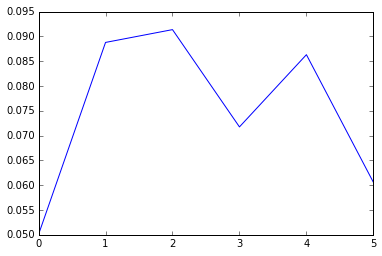

In [155]:
scores_ = []

for k in [2, 3, 4, 5, 6, 7]:
    clust_clf = ClusteringClassifier(n_clusters=k, n_estimators=50)
    clust_clf.fit(spam_X_train, spam_y_train)
    
    scores_.append(precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((clust_clf.predict(spam_X_test)+1)/2, dtype=int))[2].mean())
    
plt.plot(scores_)

In [ ]:
clust_clf = ClusteringClassifier(n_clusters=4, n_estimators=300)
clust_clf.fit(spam_X_train, spam_y_train)
print "Final F1 score: ", precision_recall_fscore_support(np.array((spam_y_test+1)/2, dtype=int), np.array((clust_clf.predict(spam_X_test)+1)/2, dtype=int))[2].mean()

Fitting gradient boosting with 300 estimators
[Fitting estimator number 1]
Score:  0.981981981982
[Fitting estimator number 2]
Score:  0.986723565671
[Fitting estimator number 3]
Score:  0.98719772404
[Fitting estimator number 4]
Score:  0.989568515884
[Fitting estimator number 5]
Score:  0.989568515884
[Fitting estimator number 6]
Score:  0.990042674253
[Fitting estimator number 7]
Score:  0.99146514936
[Fitting estimator number 8]
Score:  0.99146514936
[Fitting estimator number 9]
Score:  0.99146514936
[Fitting estimator number 10]
Score:  0.990990990991
[Fitting estimator number 11]
Score:  0.99146514936
[Fitting estimator number 12]
Score:  0.99146514936
[Fitting estimator number 13]
Score:  0.99146514936
[Fitting estimator number 14]
Score:  0.991939307729
[Fitting estimator number 15]
Score:  0.992413466098
[Fitting estimator number 16]
Score:  0.991939307729
[Fitting estimator number 17]
Score:  0.992887624467
[Fitting estimator number 18]
Score:  0.993361782835
[Fitting estimat